1. Frame Extraction

In [ ]:
import cv2
import os

def extract_frames(video_path, output_folder, frames_per_second):
    if not os.path.isfile(video_path):
        print(f"Error: Video file not found at {video_path}")
        return
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"Video FPS: {fps}")
    
    frame_interval = fps // frames_per_second
    print(f"Frame Interval: {frame_interval}")
    
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break

        if frame_count % frame_interval == 0:

            output_file = os.path.join(output_folder, f"vid_{frame_count // frame_interval}.jpg")
            print(f"Saving frame {frame_count // frame_interval} to {output_file}")
            
            cv2.imwrite(output_file, frame)
        
        frame_count += 1
    
    cap.release()
    print("Frame extraction completed.")

video_path = "/Users/marcell/Documents/WorkSpace/Education/TEEP/Others/Full.MOV"
output_folder = "/Users/marcell/Documents/WorkSpace/Education/TEEP/Frame Extraction/Frame-03"
frames_per_second = 2

os.makedirs(output_folder, exist_ok=True)
extract_frames(video_path, output_folder, frames_per_second)


2. Dataset Seperation

In [ ]:
import os
import random
import shutil

dataset_dir = r"/Users/marcell/Documents/WorkSpace/Education/TEEP/Frame Extraction/Frame-02" 
output_dir = r"/Users/marcell/Documents/WorkSpace/Education/TEEP/Frame Extraction/Dataset-02" 

splits = ["train", "test"]
for split in splits:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

images = [f for f in os.listdir(dataset_dir) if os.path.isfile(os.path.join(dataset_dir, f))]

random.shuffle(images)

total = len(images)
train_size = int(0.7 * total)  #70% training
test_size = total - train_size

train_files = images[:train_size]
test_files = images[train_size:]

def copy_files(file_list, dest_folder):
    for file in file_list:
        src = os.path.join(dataset_dir, file)
        dst = os.path.join(output_dir, dest_folder, file)
        shutil.copy(src, dst)

copy_files(train_files, "train")
copy_files(test_files, "test")

print(f"Total images: {total}")
print(f"Train: {len(train_files)}")
print(f"Test:  {len(test_files)}")

3. Training Program (DeepLabV3plus and ResNet-101)

In [ ]:
import os
import json
import math
import time
import random
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import LambdaLR
import segmentation_models_pytorch as smp

import seaborn as sns
import matplotlib.pyplot as plt


# ---------------- CONFIG ----------------
TRAIN_IMAGES = r"C:\Workspace\TEEP\ModelTraining\Program\Dataset\train\images"
TRAIN_LABELS = r"C:\Workspace\TEEP\ModelTraining\Program\Dataset\train\labels"
TEST_IMAGES  = r"C:\Workspace\TEEP\ModelTraining\Program\Dataset\test\images"
TEST_LABELS  = r"C:\Workspace\TEEP\ModelTraining\Program\Dataset\test\labels"

LABEL_NAME_TO_ID: Dict[str, int] = {
    "background": 0,
    "encrusting": 1,
    "softcoral":  2,
    "plate":      3,
    "massive":    4,
    "folios":     5,
    "branching":  6,
}
INTENDED_TOTAL_CLASSES = 7
IGNORE_INDEX = 255

NUM_EPOCHS   = 30
BATCH_SIZE   = 8
LR           = 1e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS  = 0
INPUT_SIZE   = (512, 512)
RANDOM_SEED  = 42

def _norm_label(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace("-", "")

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def find_image_label_pairs(images_dir: str, labels_dir: str):
    img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
    images = [p for p in Path(images_dir).iterdir() if p.suffix.lower() in img_exts and p.is_file()]
    pairs = []
    for img in images:
        js = Path(labels_dir) / f"{img.stem}.json"
        if js.exists():
            pairs.append((img, js))
    return pairs

def labelme_json_to_mask(json_path: Path, size_wh, name2id, ignore_idx):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    W, H = size_wh
    mask = Image.new("L", (W, H), color=0)
    draw = ImageDraw.Draw(mask)
    for shp in data.get("shapes", []):
        label = _norm_label(shp.get("label", ""))
        pts = shp.get("points", [])
        t = shp.get("shape_type", "polygon")
        cls_id = name2id.get(label, ignore_idx)
        poly = [tuple(pt) for pt in pts]
        if t == "rectangle" and len(poly) >= 2:
            (x1, y1), (x2, y2) = poly[0], poly[1]
            poly = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
        if t in ("polygon", "rectangle") and len(poly) >= 3:
            draw.polygon(poly, fill=int(cls_id))
        elif t == "circle" and len(poly) >= 2:
            (cx, cy), (px, py) = poly[0], poly[1]
            r = math.hypot(px - cx, py - cy)
            draw.ellipse([cx - r, cy - r, cx + r, cy + r], fill=int(cls_id))
    return mask


class LabelMeSegmentation(Dataset):
    def __init__(self, pairs, name2id, input_size, augment=False, ignore_idx=255):
        self.pairs = pairs
        self.name2id = name2id
        self.input_size = input_size
        self.augment = augment
        self.ignore_idx = ignore_idx

    def __len__(self): return len(self.pairs)

    def _augment(self, img, mask):
        if random.random() < 0.5: img = TF.hflip(img); mask = TF.hflip(mask)
        if random.random() < 0.1: img = TF.vflip(img); mask = TF.vflip(mask)
        if random.random() < 0.2:
            k = random.choice([1, 2, 3])
            img = img.rotate(90 * k, resample=Image.BILINEAR)
            mask = mask.rotate(90 * k, resample=Image.NEAREST)
        return img, mask

    def __getitem__(self, idx):
        img_p, js_p = self.pairs[idx]
        img = Image.open(img_p).convert("RGB")
        W, H = img.size
        mask = labelme_json_to_mask(js_p, (W, H), self.name2id, self.ignore_idx)
        img = img.resize(self.input_size[::-1], Image.BILINEAR)
        mask = mask.resize(self.input_size[::-1], Image.NEAREST)
        if self.augment:
            img, mask = self._augment(img, mask)
        img = TF.normalize(TF.to_tensor(img),
                           mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask


@torch.no_grad()
def compute_confmat(pred, target, num_classes, ignore_idx):
    mask = target != ignore_idx
    valid_pred = pred[mask].view(-1)
    valid_tgt = target[mask].view(-1)
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64, device=pred.device)
    k = valid_tgt * num_classes + valid_pred
    bincount = torch.bincount(k, minlength=num_classes**2)
    cm += bincount.reshape(num_classes, num_classes)
    return cm.cpu().numpy()


@torch.no_grad()
def compute_metrics(pred, target, num_classes, ignore_idx):
    mask = target != ignore_idx
    if mask.sum() == 0: return 0.0, 0.0
    correct = (pred[mask] == target[mask]).sum().item()
    total = mask.sum().item()
    pixel_acc = correct / total
    cm = compute_confmat(pred, target, num_classes, ignore_idx)
    inter = np.diag(cm)
    union = cm.sum(1) + cm.sum(0) - inter
    miou = np.mean(inter / np.clip(union, 1, None))
    return pixel_acc, miou, cm


def main():
    set_seed(RANDOM_SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_pairs = find_image_label_pairs(TRAIN_IMAGES, TRAIN_LABELS)
    test_pairs  = find_image_label_pairs(TEST_IMAGES, TEST_LABELS)
    random.shuffle(train_pairs); random.shuffle(test_pairs)

    train_ds = LabelMeSegmentation(train_pairs, LABEL_NAME_TO_ID, INPUT_SIZE, True, IGNORE_INDEX)
    test_ds  = LabelMeSegmentation(test_pairs, LABEL_NAME_TO_ID, INPUT_SIZE, False, IGNORE_INDEX)
    pin = device.type == "cuda"
    train_dl = DataLoader(train_ds, BATCH_SIZE, True,  num_workers=NUM_WORKERS, pin_memory=pin)
    test_dl  = DataLoader(test_ds,  BATCH_SIZE, False, num_workers=NUM_WORKERS, pin_memory=pin)

    model = smp.DeepLabV3Plus(
        encoder_name="resnet101",
        encoder_weights="imagenet",
        in_channels=3,
        classes=INTENDED_TOTAL_CLASSES
    ).to(device)

    crit = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    warmup = 5
    def lr_lambda(ep):
        if ep < warmup: return (ep+1)/warmup
        p = (ep - warmup)/max(1, NUM_EPOCHS - warmup)
        return 0.1 + 0.9 * 0.5 * (1 + math.cos(math.pi*p))
    sched = LambdaLR(opt, lr_lambda=lr_lambda)
    scaler = torch.cuda.amp.GradScaler(enabled=device.type=="cuda")

    metrics_root = Path("Result/metrics")
    metrics_root.mkdir(parents=True, exist_ok=True)
    ckpt_path = metrics_root / "deeplabv3plus_resnet50_best.pt"
    best_miou = -1.0
    history = []

    for epoch in range(1, NUM_EPOCHS+1):
        model.train()
        total_loss = 0
        accs, mious = [], []
        for imgs, masks in train_dl:
            imgs, masks = imgs.to(device), masks.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
                out = model(imgs)
                loss = crit(out, masks)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            total_loss += loss.item()*imgs.size(0)
            preds = out.argmax(1)
            acc, miou, _ = compute_metrics(preds, masks, INTENDED_TOTAL_CLASSES, IGNORE_INDEX)
            accs.append(acc); mious.append(miou)
        sched.step()

        train_loss = total_loss/len(train_dl.dataset)
        train_acc = np.mean(accs); train_miou = np.mean(mious)
        print(f"Epoch {epoch:03d}: loss={train_loss:.4f} acc={train_acc:.4f} mIoU={train_miou:.4f}")

        model.eval()
        all_cm = np.zeros((INTENDED_TOTAL_CLASSES, INTENDED_TOTAL_CLASSES), dtype=np.int64)
        val_accs, val_mious = [], []
        for imgs, masks in test_dl:
            imgs, masks = imgs.to(device), masks.to(device)
            with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
                out = model(imgs)
            preds = out.argmax(1)
            acc, miou, cm = compute_metrics(preds, masks, INTENDED_TOTAL_CLASSES, IGNORE_INDEX)
            val_accs.append(acc); val_mious.append(miou)
            all_cm += cm

        val_acc, val_miou = np.mean(val_accs), np.mean(val_mious)
        history.append({"epoch": epoch, "train_loss": train_loss,
                        "train_acc": train_acc, "train_miou": train_miou,
                        "val_acc": val_acc, "val_miou": val_miou})

        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), ckpt_path)
            print(f"[INFO] saved best model (mIoU={best_miou:.4f})")

        epoch_dir = metrics_root / f"epoch_{epoch:02d}"
        epoch_dir.mkdir(exist_ok=True)
        cm_df = pd.DataFrame(all_cm,
                             index=[f"True_{i}" for i in range(INTENDED_TOTAL_CLASSES)],
                             columns=[f"Pred_{i}" for i in range(INTENDED_TOTAL_CLASSES)])
        metrics_df = pd.DataFrame(history)
        excel_path = epoch_dir / "training_metrics.xlsx"
        with pd.ExcelWriter(excel_path) as writer:
            metrics_df.to_excel(writer, sheet_name="Metrics", index=False)
            cm_df.to_excel(writer, sheet_name=f"ConfusionMatrix_Epoch{epoch}", index=True)

        plt.figure(figsize=(8,6))
        sns.heatmap(all_cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[f"Pred_{i}" for i in range(INTENDED_TOTAL_CLASSES)],
                    yticklabels=[f"True_{i}" for i in range(INTENDED_TOTAL_CLASSES)])
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(f"Confusion Matrix Epoch {epoch}")
        plt.tight_layout()
        plt.savefig(epoch_dir / f"confusion_matrix_epoch{epoch}.png")
        plt.close()

    print(f"[DONE] Best model saved at {ckpt_path}")


if __name__ == "__main__":
    main()

c:\Users\marce\anaconda3\envs\MEST\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:189: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.type=="cuda")
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 001: loss=1.5418 acc=0.5874 mIoU=0.1432


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.2275)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 002: loss=1.0131 acc=0.8701 mIoU=0.2511


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.2727)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 003: loss=0.6588 acc=0.9072 mIoU=0.2834


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.2898)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 004: loss=0.4716 acc=0.9186 mIoU=0.3221


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.3166)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 005: loss=0.3973 acc=0.9190 mIoU=0.3340


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.3600)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 006: loss=0.2997 acc=0.9343 mIoU=0.3751


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.3609)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 007: loss=0.2296 acc=0.9471 mIoU=0.4137


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4077)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 008: loss=0.2143 acc=0.9469 mIoU=0.4149


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 009: loss=0.1801 acc=0.9543 mIoU=0.4464


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 010: loss=0.1491 acc=0.9627 mIoU=0.4650


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4245)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 011: loss=0.1280 acc=0.9679 mIoU=0.4858


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4471)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 012: loss=0.1314 acc=0.9649 mIoU=0.4894


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 013: loss=0.1154 acc=0.9692 mIoU=0.5016


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4586)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 014: loss=0.1039 acc=0.9715 mIoU=0.5047


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4684)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 015: loss=0.0907 acc=0.9753 mIoU=0.5213


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4695)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 016: loss=0.0959 acc=0.9725 mIoU=0.5161


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4750)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 017: loss=0.0858 acc=0.9767 mIoU=0.5249


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 018: loss=0.0770 acc=0.9788 mIoU=0.5452


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4809)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 019: loss=0.0683 acc=0.9807 mIoU=0.5382


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 020: loss=0.0671 acc=0.9809 mIoU=0.5420


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4849)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 021: loss=0.0657 acc=0.9810 mIoU=0.5495


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 022: loss=0.0599 acc=0.9829 mIoU=0.5493


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 023: loss=0.0544 acc=0.9843 mIoU=0.5455


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4892)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 024: loss=0.0564 acc=0.9830 mIoU=0.5460


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 025: loss=0.0565 acc=0.9836 mIoU=0.5545


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 026: loss=0.0549 acc=0.9838 mIoU=0.5557


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 027: loss=0.0517 acc=0.9849 mIoU=0.5540


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 028: loss=0.0502 acc=0.9853 mIoU=0.5502


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 029: loss=0.0471 acc=0.9862 mIoU=0.5676


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 030: loss=0.0472 acc=0.9860 mIoU=0.5682


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4895)
[DONE] Best model saved at Result\metrics\deeplabv3plus_resnet50_best.pt


4. Coral Recognition

In [ ]:
import os, math, csv, tempfile
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps, ImageFile, ImageDraw,ImageFont
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch.cuda.amp import autocast
import segmentation_models_pytorch as smp
from scipy import ndimage

ORTHO_PATH   = r"C:\Workspace\TEEP\ModelTraining\Program\Test\Ortho.png"
MODEL_PATH   = r"C:\Workspace\TEEP\ModelTraining\MEST\Model\deeplabv3plus_resnet101.pt"
OUT_DIR      = r"C:\Workspace\TEEP\ModelTraining\Program\Result"

NUM_CLASSES = 7
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PIXEL_SIZE_M = 0.000428

# class → color
ID_TO_COLOR = np.array([
    [0,0,0],        # background
    [220,20,60],    # encrusting
    [0,128,0],      # softcoral
    [70,130,180],   # plate
    [255,165,0],    # massive
    [138,43,226],   # folios
    [255,255,0],    # branching
], dtype=np.uint8)

CLASS_PREFIX = {
    1: "E",  # encrusting
    2: "S",  # soft coral
    3: "P",  # plate
    4: "M",  # massive
    5: "F",  # folios
    6: "B",  # branching
}

TILE = 768
OVERLAP = 128
BATCH = 4
USE_AMP = True

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def load_model():
    model = smp.DeepLabV3Plus(
        encoder_name="resnet101",
        encoder_weights=None,
        in_channels=3,
        classes=NUM_CLASSES
    )
    ckpt = torch.load(MODEL_PATH, map_location="cpu")
    state = ckpt.get("model_state", ckpt)
    clean = {k.replace("module.", ""): v for k, v in state.items()}
    model.load_state_dict(clean, strict=False)
    return model.to(DEVICE).eval()

to_tensor = T.Compose([
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

def infer_large(model, img):
    W, H = img.size
    pad_w = (TILE - W % TILE) % TILE
    pad_h = (TILE - H % TILE) % TILE
    img_pad = ImageOps.expand(img, (0,0,pad_w,pad_h))
    WP, HP = img_pad.size

    acc = np.zeros((NUM_CLASSES, HP, WP), np.float32)
    cnt = np.zeros((HP, WP), np.float32)

    win = torch.hann_window(TILE, device=DEVICE)
    win = (win[:,None] * win[None,:]).clamp_min(1e-3)

    xs = range(0, WP-TILE+1, TILE-OVERLAP)
    ys = range(0, HP-TILE+1, TILE-OVERLAP)

    tiles, coords = [], []

    for y in ys:
        for x in xs:
            crop = img_pad.crop((x,y,x+TILE,y+TILE))
            tiles.append(to_tensor(crop))
            coords.append((x,y))

            if len(tiles) == BATCH:
                run_batch(model, tiles, coords, acc, cnt, win)
                tiles, coords = [], []

    if tiles:
        run_batch(model, tiles, coords, acc, cnt, win)

    acc = acc[:, :H, :W] / np.maximum(cnt[:H,:W], 1e-6)
    return np.argmax(acc, axis=0).astype(np.uint8)

def run_batch(model, tiles, coords, acc, cnt, win):
    batch = torch.stack(tiles).to(DEVICE)
    with torch.no_grad(), autocast(enabled=(USE_AMP and DEVICE=="cuda")):
        probs = F.softmax(model(batch), dim=1)
    probs = probs.cpu().numpy()
    win = win.cpu().numpy()

    for i,(x,y) in enumerate(coords):
        acc[:,y:y+TILE,x:x+TILE] += probs[i] * win
        cnt[y:y+TILE,x:x+TILE] += win

def label_instances_and_coverage(mask):
    instance_map = np.zeros_like(mask, dtype=np.uint16)
    records = []
    cur_id = 1

    total_coral_pixels = (mask != 0).sum()

    for cls, prefix in CLASS_PREFIX.items():
        labeled, n = ndimage.label(mask == cls, structure=np.ones((3,3)))
        for i in range(1, n+1):
            region = (labeled == i)
            pix = int(region.sum())

            if pix == 0:
                continue

            percentage = pix / total_coral_pixels * 100
            area_m2 = pix * (PIXEL_SIZE_M ** 2)

            instance_map[region] = cur_id
            records.append([
                cur_id,
                cls,
                f"{prefix}{i}",
                pix,
                round(percentage, 2),
                round(area_m2, 4)
            ])
            cur_id += 1

    return instance_map, records

def save_overlay_tiled(img_pil, mask_uint8, out_path,
                       tile=1024, alpha_num=2, alpha_den=5):

    assert img_pil.mode == "RGB"
    W, H = img_pil.size
    out = Image.new("RGB", (W, H))

    a = alpha_num
    b = alpha_den - alpha_num
    den = alpha_den

    for y0 in range(0, H, tile):
        for x0 in range(0, W, tile):
            x1 = min(x0 + tile, W)
            y1 = min(y0 + tile, H)

            base_tile = np.asarray(
                img_pil.crop((x0, y0, x1, y1)),
                dtype=np.uint16
            )

            mask_tile = mask_uint8[y0:y1, x0:x1]
            color_tile = ID_TO_COLOR[mask_tile].astype(np.uint16)

            mix = (b * base_tile + a * color_tile + den // 2) // den
            mix = mix.astype(np.uint8)

            out.paste(Image.fromarray(mix, mode="RGB"), (x0, y0))

    out.save(out_path)

def draw_instance_labels(
    overlay_path,
    instance_map,
    records,
    out_path,
    font_size=40
):
    img = Image.open(overlay_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()

    for rec in records:
        instance_id, cls_id, label, pix, *_ = rec

        ys, xs = np.where(instance_map == instance_id)
        if len(xs) == 0:
            continue

        cx = int(xs.mean())
        cy = int(ys.mean())

        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            draw.text((cx+dx, cy+dy), label, fill=(0,0,0), font=font)

        draw.text((cx, cy), label, fill=(255,255,255), font=font)

    img.save(out_path)


def main():
    os.makedirs(OUT_DIR, exist_ok=True)

    img = Image.open(ORTHO_PATH).convert("RGB")
    model = load_model()

    print("[INFO] Running inference...")
    with tempfile.TemporaryDirectory() as _:
        mask = infer_large(model, img)

    instance_map, records = label_instances_and_coverage(mask)
    Image.fromarray(instance_map).save(Path(OUT_DIR, "mask.png"))

    overlay_path = Path(OUT_DIR, "overlay.png")
    save_overlay_tiled(
        img,
        mask,
        overlay_path,
        tile=1024,
        alpha_num=2,
        alpha_den=5
    )

    csv_path = Path(OUT_DIR, "coverage-2.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "InstanceID",
            "ClassID",
            "Label",
            "PixelCount",
            "Percentage (%)",
            "Area (m2)"
        ])
        writer.writerows(records)

    print("\n[SAVED]")
    print("semantic_mask.png")
    print("instance_mask.png")
    print("overlay.png")
    print("overlay_labeled.png")
    print("species_coverage.csv")

if __name__ == "__main__":
    main()

c:\Users\marce\anaconda3\envs\MEST\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Running inference...


C:\Users\marce\AppData\Local\Temp\ipykernel_19356\2031584364.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=(USE_AMP and DEVICE=="cuda")):
C:\Users\marce\AppData\Local\Temp\ipykernel_19356\2031584364.py:174: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  out.paste(Image.fromarray(mix, mode="RGB"), (x0, y0))



[SAVED]
semantic_mask.png
instance_mask.png
overlay.png
overlay_labeled.png
species_coverage.csv


5. Coverage Calculation

Wrote C:\Workspace\TEEP\ModelTraining\MEST\Results\coverage.csv
Total pixels : 344891660
Total area   : 46.453113 m^2
Wrote C:\Workspace\TEEP\ModelTraining\MEST\Results\coverage.png


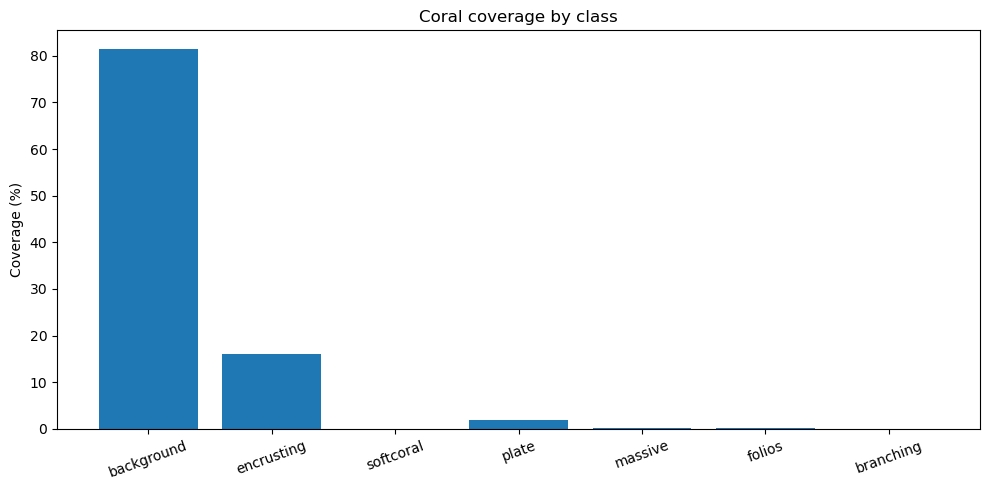

In [4]:
import csv
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

MASK_PATH = r"C:\Workspace\TEEP\ModelTraining\MEST\Results\semantic_mask.png"
CSV_PATH  = r"C:\Workspace\TEEP\ModelTraining\MEST\Results\coverage.csv"
PLOT_PATH = r"C:\Workspace\TEEP\ModelTraining\MEST\Results\coverage.png"

PIXEL_SIZE_M = 0.000367 

CLASS_NAMES = ["background","encrusting","softcoral","plate","massive","folios","branching"]

def main():
    mask = np.array(Image.open(MASK_PATH))
    total_px = mask.size
    counts = [(mask == i).sum() for i in range(len(CLASS_NAMES))]
    areas_m2 = [c * (PIXEL_SIZE_M**2) for c in counts]
    total_area_m2 = total_px * (PIXEL_SIZE_M**2)
    percents = [100.0 * a / total_area_m2 if total_area_m2 > 0 else 0 for a in areas_m2]
    Path(CSV_PATH).parent.mkdir(parents=True, exist_ok=True)
    with open(CSV_PATH, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["class", "pixels", "area_m2", "percent"])

        for cls, px, am2, p in zip(CLASS_NAMES, counts, areas_m2, percents):
            w.writerow([cls, int(px), f"{am2:.6f}", f"{p:.3f}"])

        w.writerow([])
        w.writerow(["TOTAL", int(total_px), f"{total_area_m2:.6f}", "100.000"])

    print(f"Wrote {CSV_PATH}")
    print(f"Total pixels : {total_px}")
    print(f"Total area   : {total_area_m2:.6f} m^2")

    plt.figure(figsize=(10,5))
    x = np.arange(len(CLASS_NAMES))
    plt.bar(x, percents)
    plt.xticks(x, CLASS_NAMES, rotation=20)
    plt.ylabel("Coverage (%)")
    plt.title("Coral coverage by class")
    plt.tight_layout()
    plt.savefig(PLOT_PATH, dpi=200)

    print(f"Wrote {PLOT_PATH}")

if __name__ == "__main__":
    main()